**Note**: *In this notebook I would be using class indexes instead of the actual names (in all the plots) as it helps with the proper labeling of the visualizations.*

In [1]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split


import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

In [34]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
main_path = '/content/drive/MyDrive/Adversarial ML/Face Dataset'
save_path = '/content/drive/MyDrive/Adversarial ML/Facial CNN model weights/cropped_images'
single_image = '/content/drive/MyDrive/Adversarial ML/Face Dataset/Amogh/IMG20240114215222.jpg'

In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

These are basically the class indexes and these are used in the labeling of all the visualizations.

In [5]:
dataset = datasets.ImageFolder(root=save_path, transform=transform)
class_to_index = dataset.class_to_idx
index_to_class = dataset.classes
print(class_to_index)
print(index_to_class)

{'Aakash': 0, 'Aditya_Sharma_12140070': 1, 'Amogh': 2, 'Animesh Singh': 3, 'Anumula Chaitanya Sai': 4, 'Aritra': 5, 'Aryan Kumar': 6, 'Kishan': 7, 'Mallikarjun': 8, 'Mohit Agarwala': 9, 'Prarabdh': 10, 'Vaibhav_Arora': 11, 'Vishesh_Thakur': 12, 'tanmoy': 13}
['Aakash', 'Aditya_Sharma_12140070', 'Amogh', 'Animesh Singh', 'Anumula Chaitanya Sai', 'Aritra', 'Aryan Kumar', 'Kishan', 'Mallikarjun', 'Mohit Agarwala', 'Prarabdh', 'Vaibhav_Arora', 'Vishesh_Thakur', 'tanmoy']


In [6]:
batch_size = 64
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Original model architecture used for training the CNN model.

In [7]:
class CNNModel(nn.Module):
  def __init__(self):
      super(CNNModel, self).__init__()

      # self.num_classes = num_classes
      # self.num_unknown_classes = num_unknown_classes


      self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
      self.act1 = nn.ReLU()
      self.drop1 = nn.Dropout(0.3)

      self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, padding=1)
      self.act2 = nn.ReLU()
      self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

      self.conv3 = nn.Conv2d(64, 32, kernel_size=(3,3), stride=1, padding=1)
      self.act3 = nn.ReLU()
      self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

      self.conv4 = nn.Conv2d(32, 16, kernel_size=(3,3), stride=1, padding=1)
      self.act4 = nn.ReLU()
      self.pool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

      self.flat = nn.Flatten()

      self.fc3 = nn.Linear(16384, 64)
      self.act3 = nn.ReLU()
      self.drop3 = nn.Dropout(0.5)

      self.fc4 = nn.Linear(64, 14)



  def forward(self, x):

      x = self.act1(self.conv1(x))
      # print(x.size())

      x = self.drop1(x)
      # print(x.size())

      x = self.act2(self.conv2(x))
      # print(x.size())

      x = self.pool2(x)
      # print(x.size())

      x = self.act3(self.conv3(x))
      # print(x.size())

      x = self.pool3(x)
      # print(x.size())

      x = self.act4(self.conv4(x))
      # print(x.size())

      x = self.pool4(x)
      # print(x.size())

      x = self.flat(x)
      # print(x.size())

      x = self.act3(self.fc3(x))
      # print(x.size())

      x = self.drop3(x)
      # print(x.size())

      x = self.fc4(x)
      # print(x.size())




      return x


In [8]:
dataset_size = len(dataset)
print("Total",dataset_size, "images")
train_size = int(0.9 * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Total 1284 images


In [9]:
criterion=nn.CrossEntropyLoss()
for X,y in train_dataloader:
    X,y = X.to(device), y.to(device)
    break

In [44]:
for xt, yt in val_dataloader:
  xt, yt = xt.to(device), yt.to(device)
  break

Below is a plotting function which would plot the respective image and its label predicted by the model.
- If the text in which the label is written is green then it is correct prediction
- If the text in which the label is written is red then it is an incorrect prediction.

In [10]:
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy())
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

Using the original (trained) model weights to initialize the CNN model.

In [11]:
# loading the pre-trained model on the face dataset.

model = CNNModel()
# model.load_state_dict(torch.load('/content/drive/MyDrive/Adversarial ML/Facial CNN model weights/Weights/model_weights_with_face_cropped_3_Adam_100_epochs.pth', map_location=torch.device('cpu')))
model.load_state_dict(torch.load('/content/drive/MyDrive/Adversarial ML/Facial CNN model weights/Weights/model_weights_with_face_cropped_3_Adam_100_epochs.pth'))
model.to(device)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (pool4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=16384, out_features=64, bias=True)
  (drop3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=64, out_features=14, bias=True)
)

Evaluating model on inputs without perturbations (on the original images).

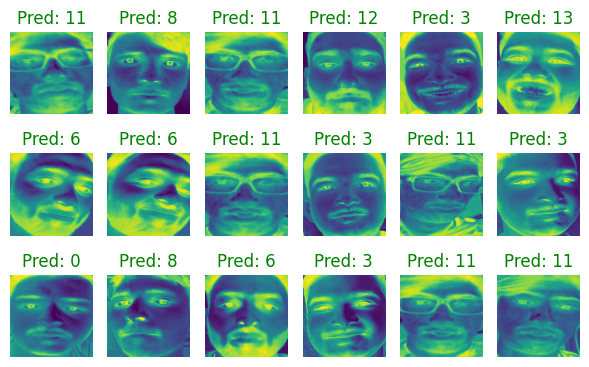

In [ ]:
model.eval()
yp = model(X)
plot_images(X, y, yp, 3, 6)

# Untargeted attacks


## FGSM Attack

Evaluating model on FGSM perturbations
- First defining a function that would calculate the delta value (perturbation value; which is just the sign of the gradient in that particular iteration).
- Then we add the delta value to the input and predict using our model.
- What we get is wrong predictions for most of the input images, making our attack successful.

In [59]:
# defining fgsm function for calculating delta

def fgsm_untargeted(model, X, y, epsilon):
    delta = torch.zeros_like(X, requires_grad=True)
    loss = criterion(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

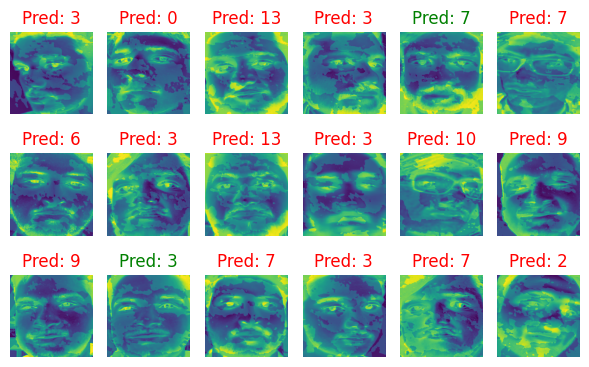

In [61]:
# adding the delta to input images and predicting the output using our trained model

delta_fgsm = fgsm_untargeted(model, X, y, 0.1)
yp = model(X + delta_fgsm)
plot_images(X+delta_fgsm, y, yp, 3, 6)

Generated adversarial patch which led to the FGSM attack can be represented as follows

In [ ]:
delta_fgsm.shape

torch.Size([64, 3, 256, 256])

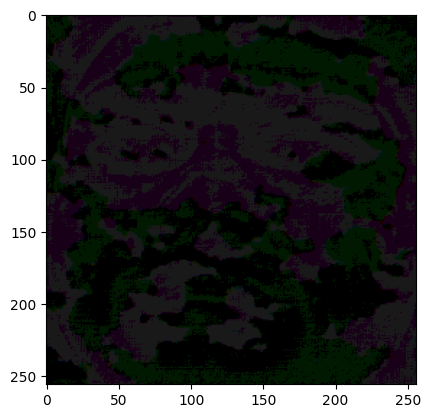

In [ ]:
# plotting the adversarial patch

delta_img_fgsm_untargeted = np.transpose(delta_fgsm[0].numpy(), (1, 2, 0))
plt.imshow(delta_img_fgsm_untargeted)

**Above is the generated adversarial perturbation using FGSM attack. This was an untargeted attack.**


## PGD Attack

Performing the PGD attack on my CNN model
- This is untargeted attack.
- First we define a function that would calculate the adversarial perturbation. PGD attack is just iterated FGSM attack. We iterate on the input data (poisoned with the perturbations) and calculate the optimal delta.
- After calculating delta, we add it to the input images and try to predict the input images using our CNN model.
- We can see that the predicted labels are wrong, making our attack on the model successful.

In [ ]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = criterion(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

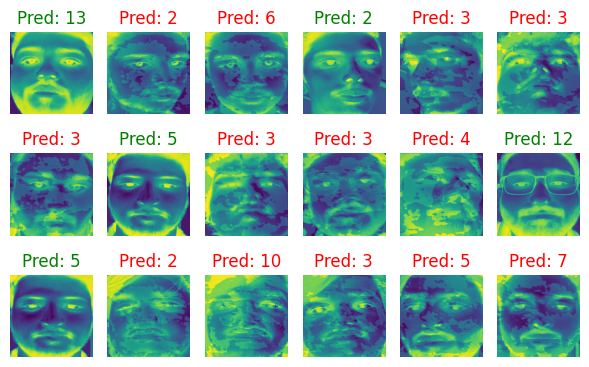

In [ ]:
delta_pgd = pgd(model, X, y, 0.1, 1e4, 10)
yp = model(X + delta_pgd)
plot_images(X+delta_pgd, y, yp, 3, 6)

# Targeted attacks

## Targeted PGD attack

**Above, untargeted attacks have been done where the output label of the input can be anything but not the original label.**

*Now, targeted attacks would be performed where the output label is decided by the attacker.*
- For the sake of demonstration, I would be giving the target label as 2 (which is Amogh in my dataset).
- I would be using PGD algorithm to define the targeted attacks.

In [ ]:
def targeted_attacks(model, X, y, epsilon, alpha, num_iter, y_targ):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

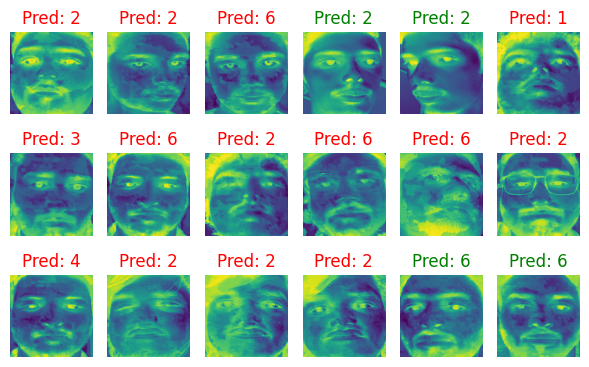

In [ ]:
delta_pgd_targeted = targeted_attacks(model, X, y, epsilon=0.2, alpha=1e-2, num_iter=10, y_targ=2)
yp = model(X + delta_pgd_targeted)
plot_images(X+delta_pgd_targeted, y, yp, 3, 6)

The above method didn't give good results, what we can do is increase the number of iterations so that we get an optimal delta that would predict all the input images as class 2.

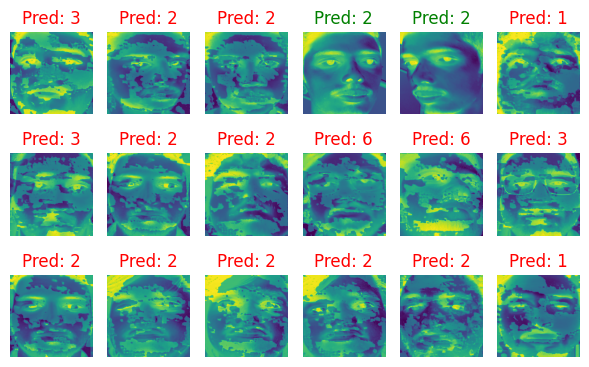

In [ ]:
delta_pgd_targeted_50_iter = targeted_attacks(model, X, y, epsilon=0.2, alpha=1e-2, num_iter=100, y_targ=2)
yp = model(X + delta_pgd_targeted_50_iter)
plot_images(X+delta_pgd_targeted_50_iter, y, yp, 3, 6)

We can see that it is a minor improvement, similarly if we increase the number of training iterations we can get a adversarial patch that would classify all the input images as Class 2 (which is our target class).

# Targeted adversarial patch attacks

### Targeted attack using a square chessboard patch of black and white pixels.



1.   First we are going to define a patch of a particular size (here its 100x100). I have defined a patch which is in the form of a chessboard.
2.   Then we are going to train the model on train_dataloader where the patch is added to the images in the dataloader and only the pixels of the patch are trained in each iteration.
3. As its an targeted attack, a target label is where the model pushes the inputs towards that label using a cross entropy loss and using Adam as the optimizer.
4. After the patch is trained, it is added to the images in validation_dataloader and the labels of the perturbed images is predicted. (The images along with the labels are plotted using the plotting funtion which is defined above)



In [39]:
target_label = torch.full((64,), 5, dtype=torch.long)
target_label = target_label.to(device)
patch_size = (100, 100)
pattern = torch.zeros(patch_size)

# defining the patch in a chess board format
pattern[::2, ::2] = 1
pattern[1::2, 1::2] = 1
pattern = pattern.repeat(3, 1, 1)
mask_tensor = torch.tensor(pattern.unsqueeze(0).float())
patch = nn.Parameter(mask_tensor.to(device), requires_grad=True)
print(patch.device)

cuda:0


<ipython-input-39-6c485ffea977>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_tensor = torch.tensor(pattern.unsqueeze(0).float())


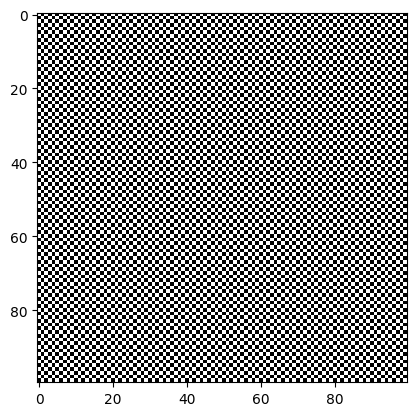

In [40]:
plt.imshow(patch[0].cpu().permute(1, 2, 0).detach().numpy())

*This is a function in which the patch is added to the image in each iteration and only those pixels of the patch are trained to get a patch which fools the model and classifies every image as a class 5.*

In [41]:
model.to(device)
print(f"Model is on device: {next(model.parameters()).device}")


def train_patch(X, y, alpha, epsilon, patch_dim, patch, num_steps, y_target):
  losses = []
  # optimizer and loss function defined
  optimizer = optim.Adam([patch], lr=0.01)
  loss_fn = nn.CrossEntropyLoss()

  # i am masking those pixels of the image which are not in the patch so that those pixels dont get trained
  mask = torch.ones((64, 3, patch_dim, patch_dim), dtype=torch.bool).to(device)
  mask[:, 50:50+patch_dim, 50:50+patch_dim] = True

  for step in tqdm(range(num_steps)):

      total_loss = 0

      optimizer.zero_grad()
      adversarial_images = X.clone()
      adversarial_images[:, :, 50:50+patch_dim, 50:50+patch_dim] += patch
      masked_patch = patch * mask.float()

      yp = model(adversarial_images)
      # print(outputs.shape)

      # minimizing the loss between the predicted label and the target label so that the model pushed the input image
      # towards the target label
      loss = loss_fn(yp, y_target)

      losses.append(loss.item())
      # print(f"Step [{step}/{num_steps}], Loss: {loss.item()}")

      loss.backward()
      optimizer.step()
      total_loss += loss
  print("\n Training loss in the first epoch is {}".format(losses[0]))
  print("Training loss in the last epoch is {}".format(losses[-1]))
  print("Training completed!")
  return patch.detach(), X, losses


Model is on device: cuda:0


In [42]:
trained_patch, images, loss_list = train_patch(X, y, alpha=1e-2, epsilon=0.1, patch_dim = 100, patch=patch, num_steps=150, y_target=target_label)

100%|██████████| 150/150 [00:44<00:00,  3.39it/s]


 Training loss in the first epoch is 8.176569938659668
Training loss in the last epoch is 0.25714007019996643
Training completed!


Plotting the loss curve, in which the x-axis is the number of iterations and the y-axis is the loss value.

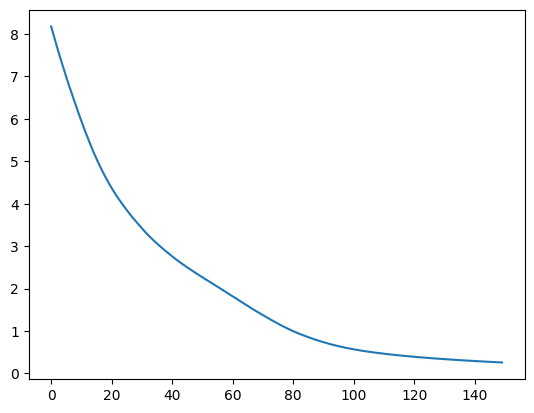

In [45]:
plt.plot(loss_list)

In [ ]:
# print(loss_list)

This function is to plot a single adversarial image along with the trained patch.

In [46]:
def plot_adv_image(X, patch_dim, trained_patch):

  adversarial_images = X.clone()
  adversarial_images[:, :, 50:50+patch_dim, 50:50+patch_dim] += trained_patch

  plt.imshow(adversarial_images[1].cpu().permute(1, 2, 0).detach().numpy())
  plt.axis('off')
  plt.show()

  return adversarial_images

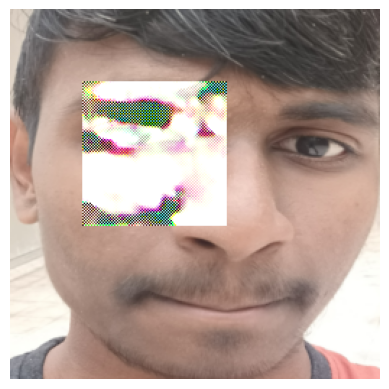

In [47]:
adv_img = plot_adv_image(xt, 100, trained_patch)

*Note: In the above image we can clearly see the patch on the face, but that is not the actual aim whether the image is visually perceptible or not. Our main aim is to train a patch which would classify any input image as a particular class.*
Ref: https://arxiv.org/pdf/1712.09665.pdf

When I evaluated my model on the adversarially perturbated input images, most of the predictions given were class 5 (which was our aim).

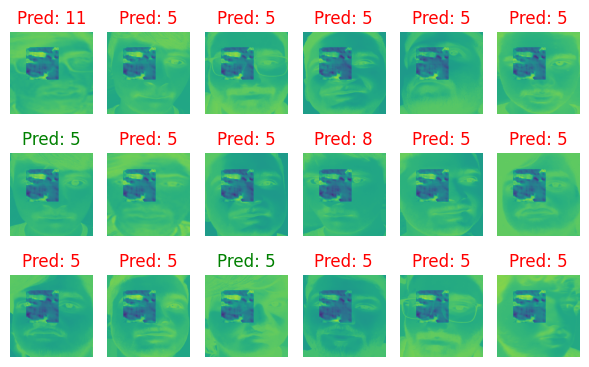

In [48]:
model.eval()
yp = model(adv_img)
plot_images(adv_img, y, yp, 3, 6)

This is the trained adversarial patch.

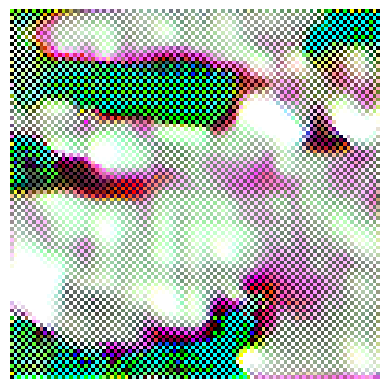

In [49]:
plt.imshow(trained_patch[0].cpu().permute(1, 2, 0).detach().numpy())
plt.axis('off')
plt.show()

### Targeted attack using a random patch.

Initializing a random patch of size 50x50.

In [50]:
patch_rand = nn.Parameter(torch.randn(3, 50, 50).to(device), requires_grad=True)

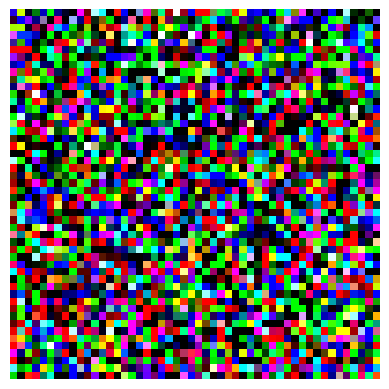

In [51]:
patch_numpy = patch_rand.cpu().permute(1, 2, 0).detach().numpy()
plt.imshow(patch_numpy)
plt.axis('off')
plt.show()

Training the model to push all the input images (images along with the random patch added) towards class 5.

In [54]:
trained_patch_rand, images, loss_list_rand = train_patch(X, y, patch_dim = 50, alpha = 1e-2, epsilon = 0.1, patch=patch_rand, num_steps=1000, y_target=target_label)

100%|██████████| 1000/1000 [04:55<00:00,  3.39it/s]


 Training loss in the first epoch is 5.395534515380859
Training loss in the last epoch is 0.03676114231348038
Training completed!


Text(0, 0.5, 'Loss')

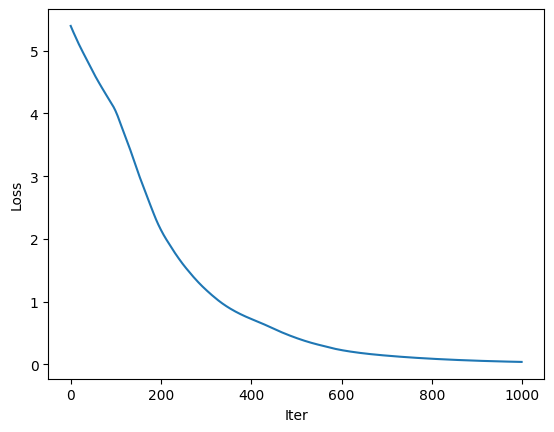

In [55]:
plt.plot(loss_list_rand)
plt.xlabel("Iter")
plt.ylabel("Loss")

In [ ]:
# print(loss_list_rand)

Image after the patch has been trained.

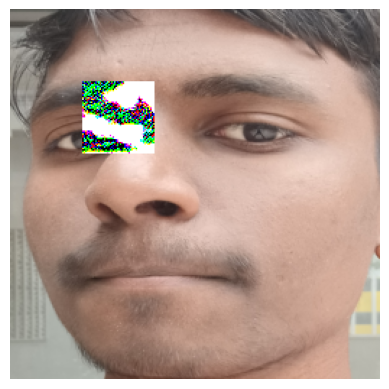

In [56]:
adv_img_rand = plot_adv_image(X, 50, trained_patch_rand)

We can see that most of the input images' predictions is label 5. (Though the images are not clearly visible, that is only because of plotting the reduced dimensions of the image. The original image which can be seen above is clearly visible)

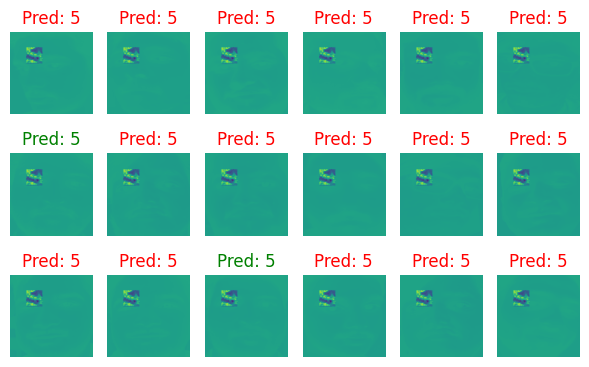

In [57]:
model.eval()
yp = model(adv_img_rand)
plot_images(adv_img_rand, y, yp, 3, 6)

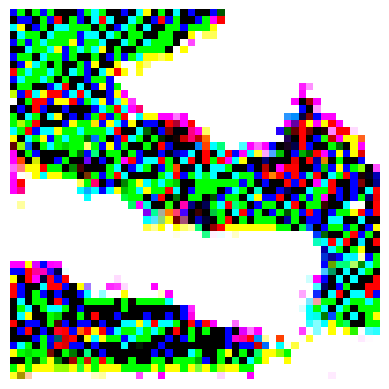

In [58]:
plt.imshow(trained_patch_rand.cpu().permute(1, 2, 0).detach().numpy())
plt.axis('off')
plt.show()

# Untargeted Adversarial Patch Attacks

### Untargeted PGD patch attack

Leveraging the PGD algorithm to attack the model. This is untargeted attack where the output label is anything other than the original label. Thus our main aim is to maximize the loss in each iteration between the original label and the predicted label.

In [21]:
patch_size_untarget = (100, 100)
pattern_untarget = torch.zeros(patch_size_untarget)
pattern_untarget[::2, ::2] = 1
pattern_untarget[1::2, 1::2] = 1
pattern_untarget = pattern_untarget.repeat(3, 1, 1)
mask_tensor_untarget = torch.tensor(pattern_untarget.unsqueeze(0).float())
patch_untarget = nn.Parameter(mask_tensor_untarget.to(device), requires_grad=True)
print(patch_untarget.device)

cuda:0


<ipython-input-21-4f4fba66e802>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_tensor_untarget = torch.tensor(pattern_untarget.unsqueeze(0).float())


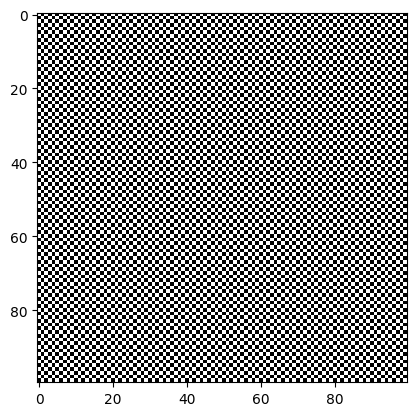

In [22]:
plt.imshow(patch_untarget[0].cpu().permute(1, 2, 0).detach().numpy())

In [23]:
def pgd_untargeted_patch(model, X, y, num_iter, epsilon, patch, patch_dim):
    losses = []
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam([patch], lr=0.01)
    for t in tqdm(range(num_iter)):
        adv_img = X.clone()
        adv_img[:, :, 100:100+patch_dim, 100:100+patch_dim] += patch
        optimizer.zero_grad()
        yp = model(adv_img)

        # the negative sign is to maximize the cross entropy loss between the predicted and the original label
        loss = -loss_fn(yp, y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        patch.data = (patch + epsilon * patch.grad.detach().sign()).clamp(-epsilon, epsilon)


    print("\n The training loss in the first iter: {}".format(losses[0]))
    print("The training loss in the last iter: {}".format(losses[-1]))
    return patch.detach(), losses

In [25]:
pgd_patch, loss_pgd = pgd_untargeted_patch(model, X, y, num_iter=300, epsilon=0.1, patch=patch_untarget, patch_dim=100)

100%|██████████| 300/300 [01:27<00:00,  3.42it/s]


 The training loss in the first iter: -0.2114478498697281
The training loss in the last iter: -0.025822842493653297


We can see that the loss is increasing in each iteration (which was original aim).

Text(0, 0.5, 'Loss')

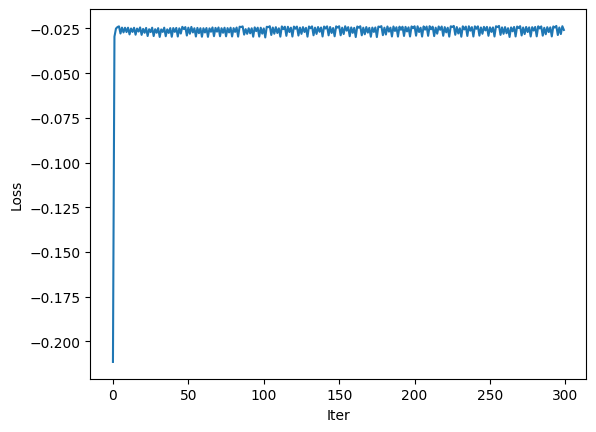

In [26]:
plt.plot(loss_pgd)
plt.xlabel("Iter")
plt.ylabel("Loss")

In [36]:
print(xt.device)

cuda:0


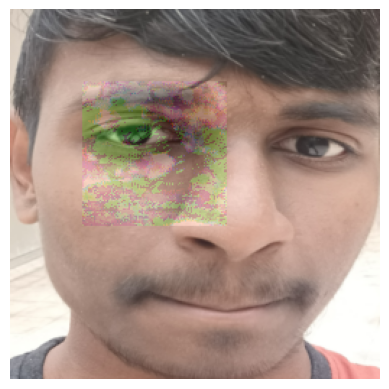

In [37]:
pgd_adv_img = plot_adv_image(xt, 100, pgd_patch)

Evaluating the model on the images from validation data loader + the patch.

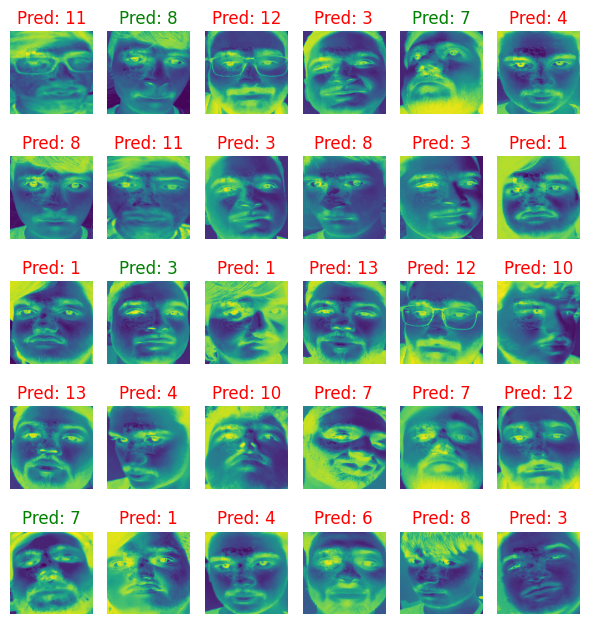

In [38]:
model.eval()
yp_pgd_patch = model(pgd_adv_img)
plot_images(pgd_adv_img, y, yp_pgd_patch, 5, 6)